# LUSD Pool Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as scp
import scipy.optimize as opt
import csv
import math
import random
import pandas as pd
import copy
from datetime import timedelta

## Core Idea
The core idea of a pool is a LUSD : staBAL pool, which utilizes StableSwap invariant and provides low slippage tool for swapping tokens equal in price (as LUSD and staBAL are both close to 1\\$: LUSD = 1.01\\$ and staBAL = 0.99$). staBAL is a BPT token of Balancer stable pool with 3 stable tokens: USDC, USDT and DAI.

Such pool has a potential to be a high-profitable mining/income tool. That is because Balacner architecture allows to stake liquidity tokens of the pool into other pools and investing mechanisms, though still maintaining the pool as if all the tokens still remain in the pool. In other words, LUSD tokens from the pool could be staked into Liquidity Stability Pool for additional profit (with some reserve left in the original pool to maintain small swaps) and perform liquidity mining for the liquidity providers of the original pool. This profits will sum with the conventional profits from swap fees and liquidity provision in the original pool, effectively adding APRs. At the time of the document creation, expected APR of Liquity Stability Pool staking is ~13%.

## Input Data

* TVL of the pool can be estimated as $2\times TVL_{staBAL}\hspace{3mm}(2\times \$163,751,787)$, as this will be $50/50$ LUSD/staBAL pool.
* The LUSD reserve is a subject of research in this document
* The pool mathematics is a stable pool by Curve (stableswap)

## Math

The following code block is Balancer's stablepool logic

In [2]:
#pool functions
def calculateInvariant_b(A, pool, roundUp):
    n = len(pool)
    S = 0
    for i in range(0, n):
        if (not(isinstance(pool[i], int))):
            raise TypeError('Not int in pool')
        S = S + pool[i]
    prevD = 0
    D = S
    An = mul(A, pow(n, n))
    for i in range(0, 255):
        P_D = pool[0]*n
        for j in range (1, n):
                P_D = div(mul(mul(P_D, pool[j]), n), D, roundUp)
        prevD = D
        D = div(
            add(mul(mul(n, D), D), mul(mul(An, S), P_D)
            ),
            add(mul(n + 1, D), mul(An - 1, P_D)
            ),
            roundUp
            )
        if (D > prevD):
            if (D - prevD <= 1):
                return D
        elif (prevD - D <= 1):
            return D

    raise NoConvergenceException('D didn\'t converge, error = ', abs(D - prevD))
    
def calculateInvariant(A, pool):
    n = len(pool)
    S = sum(pool)
    P = 1
    for i in range(0, n):
        P = P*pool[i]
    t = pow(n, n)
    D = S
    T = A*t
    
    for i in range(0, 255):
        prevD = D
        K = pow(D, n)/(t*P)
        D = (n*K*D + T*S)/(T + (n+1)*K - 1)
        if (D > prevD):
            if (D - prevD <= 1):
                return D
        elif (prevD - D <= 1):
            return D
    raise NoConvergenceException('D didn\'t converge')
        


def getTokenBalanceGivenInvariantAndAllOtherBalances_b(A, pool, D, tokenindex):
    n = len(pool)
    S = pool[0]
    P_D = pool[0]*n
    for j in range(1, n):
        P_D = divDown(mul(mul(P_D, pool[j]), n), D)
        S = add(S, pool[j])
    S = sub(S, pool[tokenindex])
    D2 = mul(D, D)
    An = int(A*pow(n, n))
    
    c = mul(
        divUp(D2, mul(An, P_D)),
        pool[tokenindex]
    )
    
    b = add(S,divDown(D, An))
    
    prevTokenBalance = 0
    
    tokenBalance = divUp(add(D2, c), add(D, b))
    
    
    for i in range(0, 255):
        prevTokenBalance = tokenBalance
        
        tokenBalance = divUp(
            add(mul(tokenBalance, tokenBalance), c),
            sub(add(mul(tokenBalance, 2), b), D)
        )
        if (tokenBalance > prevTokenBalance):
            if (tokenBalance - prevTokenBalance <= 1000):
                return tokenBalance
        elif (prevTokenBalance - tokenBalance <= 1000):
            return tokenBalance
        
    raise NoConvergenceException('balance didn\'t converge, error = ', abs(tokenBalance - prevTokenBalance))
        
def getTokenBalanceGivenInvariantAndAllOtherBalances(A, pool, D, tokenindex):
    n = len(pool)
    S = 0
    P = 1
    for i in range(0, n):
        if (i != tokenindex):
            S = S + pool[i]
            P = P*pool[i]
    t = pow(n, n) #N
    G = A*t #A
    K = pow(D, n+1)/(P*t)
    L = G*S + D - G*D
    x = D
    for i in range(0, 255):
        x = (pow(x, 2)*G + K)/(L + 2*x*G)
    return x
    
        
def calcOutGivenIn_b(A, pool, tokenin, tokenout, amountin):
    D = calculateInvariant_b(A, pool, True)
    pool[tokenin] = add(pool[tokenin], amountin)
    finalBalanceOut = getTokenBalanceGivenInvariantAndAllOtherBalances_b(A, pool, D, tokenout)
    pool[tokenin] = pool[tokenin] - amountin
    return sub(sub(pool[tokenout], finalBalanceOut), 1)

def calcOutGivenIn(A, pool, tokenin, tokenout, amountin):
    D = calculateInvariant(A, pool)
    pool[tokenin] = pool[tokenin] + amountin
    xout = getTokenBalanceGivenInvariantAndAllOtherBalances(A, pool, D, tokenout)
    pool[tokenin] = pool[tokenin] - amountin
    return pool[tokenout] - xout


def calcInGivenOut_b(A, pool, tokenin, tokenout, amountout):
    D = calculateInvariant_b(A, pool, True)
    pool[tokenout] = sub(pool[tokenout], amountout)
    finalBalanceIn = getTokenBalanceGivenInvariantAndAllOtherBalances_b(A, pool, D, tokenin)
    pool[tokenout] = pool[tokenout] + amountout
    return add(sub(finalBalanceIn, pool[tokenin]), 1)

def calcInGivenOut(A, pool_, tokenin, tokenout, amountout):
    pool = copy.deepcopy(pool_)
    D = calculateInvariant(A, pool) 
    pool[tokenout] = pool[tokenout] - amountout
    finalBalanceIn = getTokenBalanceGivenInvariantAndAllOtherBalances(A, pool, D, tokenin)
    return finalBalanceIn - pool[tokenin]

def calcBptOutGivenExactTokensIn(A, pool, amountsin, bpttotalsupply, swapfeepercentage):
    n = len(pool)
    n2 = len(amountsin)
    if (n != n2):
        print('pool and amounts_in have different dimensions: ', n, n2)
        return
    S = pool[0]
    for j in range(1, n):
        S = add(S, pool[j])
    balanceRatiosWithFee = [0 for i in range(n)]
    invariantRatioWithFees = 0
    for i in range(0, n):
        currentWeight = divDown_f(pool[i], S)
        balanceRatiosWithFee[i] = divDown_f(add(pool[i], amountsin[i]), pool[i])
        invariantRatioWithFees = add(invariantRatioWithFees, mulDown_f(balanceRatiosWithFee[i], currentWeight))
    print(balanceRatiosWithFee)
    print(invariantRatioWithFees)
        
    newpool = [0 for i in range(n)]
    for i in range(0, n):
        if (balanceRatiosWithFee[i] > invariantRatioWithFees):
            nonTaxableAmount = mulDown_f(pool[i], sub(invariantRatioWithFees, ONE))
            taxableAmount = sub(amountsin[i], nonTaxableAmount)
            amountInWithoutFee = add(nonTaxableAmount, mulDown_f(taxableAmount, ONE - swapfeepercentage))
        else:
            amountInWithoutFee = amountsin[i]
            
        newpool[i] = add(pool[i], amountInWithoutFee)
        
    currentD = calculateInvariant_b(A, pool, True)
    newD = calculateInvariant_b(A, newpool, False)
    invariantRatio = divDown_f(newD, currentD)
    if (invariantRatio > 1):
        return mulDown_f(bpttotalsupply, (invariantRatio - ONE))
    else:
        return 0
    
def calcTokenInGivenExactBptOut(A, pool, token, bptamountout, bpttotalsupply):
    D = calculateInvariant(A, pool)
    newD = (bpttotalsupply + bptamountout)/(bpttotalsupply)*D
    newBalanceToken = getTokenBalanceGivenInvariantAndAllOtherBalances(A, pool, newD, token)
    amountInWithoutFee = newBalanceToken - pool[token]
    S = sum[pool]
    currentWeight = pool[token]/S
    taxablePercentage = 1 - currentWeight
    taxableAmount = amountInWithoutFee*taxablePercentage
    nonTaxableAmount = amountInWithoutFee - taxableAmount
    
    return nonTaxableAmount + taxableAmount/(1-swapfeepercentage)

def calcBptInGivenExactTokensOut(A, pool, amountsout, bpttotalsupply):
    S = sum(pool)
    balanceRatiosWithoutFee = []
    invariantRatioWithoutFees = 0
    for i in range(0, n):
        currentWeight = pool[i]/S
        balanceRatiosWithoutFee[i] = (pool[i]-amountsout[i])/pool[i]
        invariantRatioWithoutFees = invariantRatioWithoutFees + balanceRatiosWithoutFee[i]*currentWeight
        
    newpool = []
    for i in range(0, n):
        if (invariantRatioWithoutFees > balanceRatiosWithoutFee[i]):
            nonTaxableAmount = pool[i]*(1-invariantRatioWithoutFees)
            taxableAmount = amountsout[i] - nonTaxableAmount
            amountOutWithFee = nonTaxableAmount + taxableAmount/(1-swapfeepercentage)
        else:
            amountOutWithFee = amountsout[i]
        newpool[i] = pool[i] - amountOutWithFee
        
    D = calculateInvariant(A, pool)
    newD = calculateInvariant(A, newpool)
    invariantRatio = newD/D
    return bpttotalsupply*(1-invariantRatio)

def calcTokenOutGivenExactBptIn(A, pool, token, bptAmountIn, bptTotalSupply, swapfeepercentage):
    D = calculateInvariant(A, pool)
    newD = (bptTotalSupply - bptAmountIn)/bptTotalSupply*D
    
    newBalanceToken = getTokenBalanceGivenInvariantAndAllOtherBalances(A, pool, newD, token)
    amountOutWithoutFee = pool[token] - newBalanceToken
    S = sum[pool]
    currentWeight = pool[token]/S
    taxablePercentage = (1-currentWeight)
    taxableAmount = amountOutWithoutFee*taxablePercentage
    nonTaxableAmount = amountOutWithoutFee - taxableAmount
    
    return nonTaxableAmount + taxableAmount*(1-swapfeepercentage)

def calcTokensOutGivenExactBptIn(pool, bptAmountIn, bptTotalSupply):
    bptRatio = bptAmountIn/bptTotalSupply
    
    amountsOut = []
    for i in range(0, n):
        amountsOut[i] = pool[i]*bptRatio
        
    return amountsOut

def calcDueTokenProtocolSwapFeeAmount(A, pool, lastD, token, protocolSwapFeePercentage):
    finalBalanceFeeToken = getTokenBalanceGivenInvariantAndAllOtherBalances(A, pool, lastD, token)
    
    if (pool[token] <= finalBalanceFeeToken):
        return 0
    
    accumulatedTokenSwapFees = pool[token] - finalBalanceFeeToken
    return accumulatedTokenSwapFees*protocolSwapFeePercentage/(1)

## Pool Utilities

### Initialisation

In [3]:
#Variables
staBAL_TVL = 163751787
staBAL_emission = 161367054
staBAL_price = staBAL_TVL/staBAL_emission # Total Value Locked / Total Emission #USD
staBAL_amount = staBAL_emission #initial amount
staBAL_APR = 0.12 #as for 14.09.2021

LUSD_TVL = staBAL_TVL #50:50
LUSD_price = 1 #USD
LUSD_amount = LUSD_TVL/LUSD_price #initial amount
LUSD_APR = 0.13

#LQTY_emission = 100000000
#LQTY_staked = 0
LQTY_price = 4.25 #USD
#LQTY_APR = 0.16


tokens = {'LUSD' : 0, 'staBAL' : 1}
#pool - LUSD:staBAL 
pool_virtual = np.array([LUSD_amount, staBAL_amount])
#pool - LUSD - LUSD_staked:staBAL
LUSD_reserve = 0 #reserve left in pool for swaps
pool = copy.deepcopy(pool_virtual)
pool[0] = LUSD_reserve

#by default we concider every LUSD that is not in reserve staked in Stability Pool

total_APR = 0 #will be calculated on-the-go

A = 1000 #stablepool coefficient


#wrapup
prices = np.array([LUSD_price, staBAL_price])
APRs = np.array([LUSD_APR, staBAL_APR])


In [4]:
'''
#Class pool

class LSpool:
    
    LUSD = 0
    staBAL = 0
    LQTY = 0
    LUSD_price = 0
    staBAL_price = 0
    LQTY_price = 0
    LUSD_APR = 0
    staBAL_APR = 0
    LQTY_APR = 0
    LUSD_reserve = 0
    LUSD_staked = 0
    LQTY_staked = 0
    
    def __init__(self, LUSD, staBAL):
        pool = np.array([LUSD, staBAL])
        self.LUSD = LUSD
        self.staBAL = staBAL
        self.pool = pool
        
    def stats(self):
        print("LUSD:staBAL pool")
        print(f"Composition: {self.LUSD}:{staBAL} LUSD:staBAL")
'''        
        

'\n#Class pool\n\nclass LSpool:\n    \n    LUSD = 0\n    staBAL = 0\n    LQTY = 0\n    LUSD_price = 0\n    staBAL_price = 0\n    LQTY_price = 0\n    LUSD_APR = 0\n    staBAL_APR = 0\n    LQTY_APR = 0\n    LUSD_reserve = 0\n    LUSD_staked = 0\n    LQTY_staked = 0\n    \n    def __init__(self, LUSD, staBAL):\n        pool = np.array([LUSD, staBAL])\n        self.LUSD = LUSD\n        self.staBAL = staBAL\n        self.pool = pool\n        \n    def stats(self):\n        print("LUSD:staBAL pool")\n        print(f"Composition: {self.LUSD}:{staBAL} LUSD:staBAL")\n'

### Calculate APR based on pool composition and LUSD_staked

In [5]:
def calc_APR(pool, pool_virtual, prices, APRs):
    TVL = sum(pool_virtual*prices)
    staBAL_APR_part = APRs[1]*pool_virtual[1]*prices[1]/TVL
    LUSD_APR_part = APRs[0]*(pool_virtual[0]-pool[0])*prices[0]/TVL
    APR_total = (staBAL_APR_part + LUSD_APR_part)
    return APR_total

### Change LUSD reserve in pool

In [6]:
def add_reserve(pool, pool_virtual, add):
    current_reserve = pool[0]
    new_reserve = current_reserve + add
    pool[0] = new_reserve
    return pool

In [7]:
def remove_reserve(pool, pool_virtual, remove):
    current_reserve = pool[0]
    new_reserve = current_reserve - remove
    if (new_reserve <= 0):
        print(f"Not enough reserve to remove! Current reserve is: {current_reserve}")
        return pool
    pool[0] = new_reserve
    return pool

remove_reserve(pool, pool_virtual, 100)

Not enough reserve to remove! Current reserve is: 0.0


array([0.00000000e+00, 1.61367054e+08])

In [8]:
def stake_LUSD(pool, pool_virtual, amount):
    free_LUSD = pool_virtual[0] - pool[0]
    if (amount >= free_LUSD):
        print(f"not enough free LUSD! Current free LUSD is: {free_LUSD}")
        return
    pool[0] -= amount
    APR = calc_APR(pool, pool_virtual, prices, APRs)
    return APR

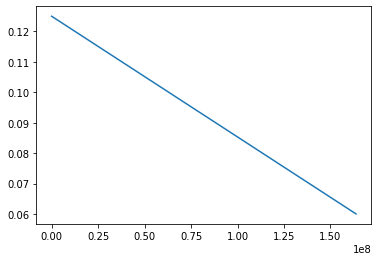

In [9]:
#example APR based on different reserve amount
pool=np.array([LUSD_amount, staBAL_amount])
pool = copy.deepcopy(pool_virtual)
pool[0] = LUSD_reserve
reserves = np.linspace(0, pool_virtual[0], 1000)
APR_graph = np.zeros((len(reserves)))
for i in range(0, len(reserves)):
    pool[0] = reserves[i]
    APR_graph[i] = calc_APR(pool, pool_virtual, prices, APRs)
    
plt.plot(reserves, APR_graph)

In [10]:
TransactionCost = 65000 #Gas
GasPrice = 55 #Gwei
EthPrice = 3000 #USD
GweiPrice = 1e-9*EthPrice #ETH

TransactionPrice = TransactionCost*GasPrice*GweiPrice
TransactionPrice

10.725

## Staking LQTY into Liquity to receive fees

The first strategy is to stake farmed LQTY into Liquity to receive share of borrow and redemption fees.

LUSD total in Pool: $32,750,357$
LUSD reserved in Pool: $3,275,036$
LUSD staked in Stability Pool: $29,475,322$
Pool TVL: $65,500,715


Daily LQTY gain from staked LUSD: 2,333 LQTY = 10,498$
Total LQTY farmed per year: 851,509
Total gain: $3,966,272
Total APR: 0.121%


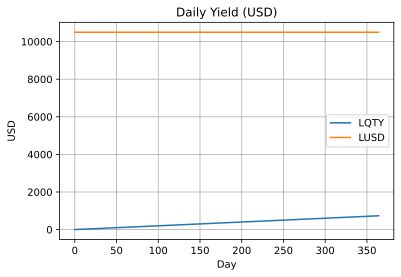

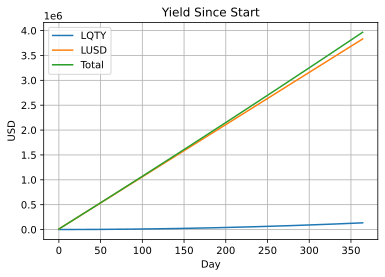

In [11]:
%config InlineBackend.figure_format = 'svg'

days = np.arange(0, 365)
LUSD_total = 556550604 #Total LUSD supply
SP_LUSD_utilization = 0.78
LUSD_in_SP = LUSD_total*SP_LUSD_utilization #LUSD in Stability Pool

pool = np.array([LUSD_amount, staBAL_amount])
prices = np.array([LUSD_price, staBAL_price])

def calcTVL(pool, prices):
    TVL = sum(pool*prices)
    return TVL

pool = pool/5

LQTY_price = 4.5
LUSD_reserve = pool[0]*0.1 #Amount of LUSD locked in the Pool
LUSD_staked = pool[0] - LUSD_reserve #Amount of LUSD staked in the Stability Pool
LQTY_amount = 0 #Total LQTY farmed
LUSD_APR = 0.13 #LQTY APR gained from staked LUSD
LUSD_DPR = LUSD_APR/365
LQTY_APR = 0.07 #APR gained from staked LQTY
LQTY_DPR = LQTY_APR/365
LQTY_farmed = np.zeros(365) #LQTY farmed at x day
LQTY_staked = np.zeros(365) #LQTY staked at x day
LQTY_daily_yield_USD = np.zeros(365) #USD farmed for all staked LQTY at x day
LUSD_daily_yield_USD = np.zeros(365) #USD farmed for all staked LUSD at x day (in LQTY)
LQTY_yield = np.zeros(365) #Total USD yield for LQTY staked at x day
LUSD_yield = np.zeros(365) #Total USD yield for LUSD staked at x day
total_yield = np.zeros(365) #Tital USD yield for everything staked at x day
    
for day in days:
    LQTY_farmed[day] = LUSD_DPR*LUSD_staked*LUSD_price/LQTY_price
    LQTY_staked[day] = LQTY_staked[day-1] + LQTY_farmed[day]
    LUSD_daily_yield_USD[day] = LQTY_farmed[day]*LQTY_price
    LQTY_daily_yield_USD[day] = LQTY_staked[day]*LQTY_price*LQTY_DPR
    LQTY_yield[day] = LQTY_yield[day-1] + LQTY_daily_yield_USD[day]
    LUSD_yield[day] = LUSD_yield[day-1] + LUSD_daily_yield_USD[day]
    total_yield[day] = LQTY_yield[day] + LUSD_yield[day]
    LQTY_amount += LQTY_farmed[day]
    
plt.plot(days, LQTY_daily_yield_USD)
plt.plot(days, LUSD_daily_yield_USD)
plt.title('Daily Yield (USD)')
plt.xlabel('Day')
plt.ylabel('USD')
plt.legend(('LQTY', 'LUSD'))
plt.grid()

plt.figure()

plt.plot(days, LQTY_yield)
plt.plot(days, LUSD_yield)
plt.plot(days, total_yield)
plt.title('Yield Since Start')
plt.xlabel('Day')
plt.ylabel('USD')
plt.legend(('LQTY', 'LUSD', 'Total'))
plt.grid()

print('LUSD total in Pool: ${:0,.0f}$'.format(pool[0]))
print('LUSD reserved in Pool: ${:0,.0f}$'.format(LUSD_reserve))
print('LUSD staked in Stability Pool: ${:0,.0f}$'.format(LUSD_staked))
TVL = calcTVL(pool, prices)
print('Pool TVL: ${:0,.0f}'.format(TVL))
print('\n')
print('Daily LQTY gain from staked LUSD: {:0,.0f} LQTY = {:0,.0f}$'.format(LQTY_farmed[0], LUSD_daily_yield_USD[0]))
print('Total LQTY farmed per year: {:0,.0f}'.format(LQTY_amount))
LQTY_price = 4.5 #$
gain = total_yield[-1]
print('Total gain: ${:0,.0f}'.format(gain))
print('Total APR: {:0,.3f}%'.format(gain/TVL*2))

### Results

* As we can see with the graphs, staking farmed LQTY tokens gives only marginal yield income.
* However, it requires almost no gas as no tokens are removed from Liquity.

Below we will compare this strategy with selling LQTY tokens for LUSD and adding it to the SP.

We will trade LQTY tokens once a week to avoid huge gas losses.

## Selling LQTY tokens to market for LUSD and restaking

In this strategy, we will sell farmed LQTY tokens for LUSD at external market and add the received LUSD to the previously staked in the Stability Pool.

### Note!

* According to the previous strategy, total LQTY income per year will be around LQTY 4,5M.
* Total LQTY emission at the time is LQTY 10M. 
* ~LQTY 8M is currently staked, leaving only $\leq$ LQTY 2M circulating in the outer market.

This means selling all LQTY 4,5M will be extremely unprofitable. We will reduce the TVL of the Pool to find the amount of LQTY that can be adequately traded for LUSD.

[32750357.4 32273410.8]
Pool Multiplier Factor: 0.2
Pool TVL: $65,500,715
Total LUSD gain per year: LUSD 3,848,837
LQTY at the end: $0
Total APR: 0.11752047019721844%


Text(0, 0.5, 'LUSD staked')

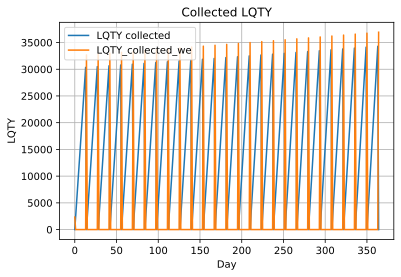

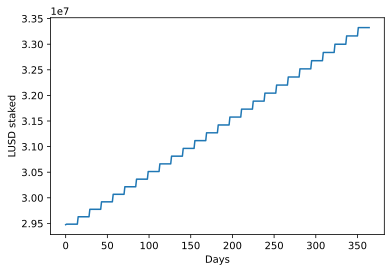

In [12]:
%config InlineBackend.figure_format = 'svg'

days = np.arange(0, 365)

pool = np.array([LUSD_amount, staBAL_amount])
prices = np.array([LUSD_price, staBAL_price])

def calcTVL(pool, prices):
    TVL = sum(pool*prices)
    return TVL

pool = pool/5

LUSD_reserve = pool[0]*0.1 #Amount of LUSD locked in the Pool
LUSD_staked = pool[0] - LUSD_reserve #Amount of LUSD staked in the Stability Pool
LQTY_amount = 0 #Total LQTY farmed
LUSD_APR = 0.13 #LQTY APR gained from staked LUSD
LUSD_DPR = LUSD_APR/365
LQTY_APR = 0.07 #APR gained from staked LQTY
LQTY_DPR = LQTY_APR/365
LQTY_farmed = np.zeros(365) #LQTY farmed at x day
LQTY_collected = np.zeros(365) #LQTY staked at x day
LQTY_collected_we = np.zeros(365)
LUSD_staked_a = np.zeros(365)
    
def sellLQTY(LQTY, price = 0, TP = 0):
    if (TP == 0):
        TP = 200
    #if (price == 0):
        price = 155000/35000
    '''slippage = 0.01 #*100%
    LUSD_received = (LQTY*LQTY_price)*(1-slippage)/LUSD_price - TP*1/LUSD_price
    return LUSD_received'''
    LUSD_received = LQTY*price
    return LUSD_received
    
for day in days:
    LUSD_staked_a[day] = LUSD_staked
    LQTY_farmed[day] = LUSD_DPR*LUSD_staked*LUSD_price/LQTY_price
    LQTY_collected[day] = LQTY_collected[day-1] + LQTY_farmed[day]
    if (day%14 == 0):
        LQTY_collected_we[day] = LQTY_collected[day]
        LQTY_collected[day] = 0
        LUSD_received = sellLQTY(LQTY_collected_we[day])
        LUSD_staked += LUSD_received
    
print(pool)
print(f'Pool Multiplier Factor: {1/5}')
TVL = calcTVL(pool, prices)
print('Pool TVL: ${:0,.0f}'.format(TVL))
LUSD_gain = LUSD_staked_a[-1] - LUSD_staked_a[0]
print('Total LUSD gain per year: LUSD {0:,.0f}'.format(LUSD_gain))
print('LQTY at the end: ${0:,.0f}'.format(LQTY_collected[day]))
print(f'Total APR: {LUSD_gain/TVL*2}%')
plt.plot(days, LQTY_collected)
plt.plot(days, LQTY_collected_we)
plt.title('Collected LQTY')
plt.xlabel('Day')
plt.ylabel('LQTY')
plt.legend(('LQTY collected', 'LQTY_collected_we'))
plt.grid()

plt.figure()

plt.plot(days, LUSD_staked_a)
plt.xlabel('Days')
plt.ylabel('LUSD staked')

## Liquity Minting
LQTY is minted by the following formula:
$$
32M*(1-0.5^{year})
$$

By 09.29.2021 approx. 10.5M of LQTY has already been distributed, leaving 5.5M LQTY to be distributed by the end of 2021.

In [13]:
def LQTYminting(year, minted = 0):
    return 32e6*(1-pow(0.5, year)) - minted

LQTYminting(1, minted = 10.5e6)

5500000.0

In [14]:
pool = np.array([LUSD_amount, staBAL_amount])
pool = pool/5



# Pool Model Based on Previous Data

### Importing Libraries

In [15]:
import csv 
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import copy

### Creating Dataframes of Different Statistics

##### Opening files

In [16]:
Total_LUSD_Supply = pd.read_csv('data/Total LUSD Supply.csv')
LUSD_Utilization = pd.read_csv('data/LUSD Utilization.csv')
Total_LQTY_Staked = pd.read_csv('data/Total LQTY Staked.csv')
Liquidations_ = pd.read_csv('data/Recent Liquidations.csv')
Redeems_ = pd.read_csv('data/Recently Redeemed Troves.csv')

In [17]:
start_date = datetime(2021, 7, 1, 0, 0, 0) #1th of July, 2021, 00:00
start_date = pd.to_datetime(start_date, utc=True)

end_date = datetime(2021, 9, 29, 11, 0, 0) #29th of September, 2021, 11:00
end_date = pd.to_datetime(end_date, utc=True)

dateColumn = pd.date_range(start_date, end_date, freq='H')
dateColumn = pd.DataFrame(dateColumn, columns=['date',])
dateColumn

,date
0,2021-07-01 00:00:00+00:00
1,2021-07-01 01:00:00+00:00
2,2021-07-01 02:00:00+00:00
3,2021-07-01 03:00:00+00:00
4,2021-07-01 04:00:00+00:00
...,...
2167,2021-09-29 07:00:00+00:00
2168,2021-09-29 08:00:00+00:00
2169,2021-09-29 09:00:00+00:00
2170,2021-09-29 10:00:00+00:00


##### Creating LUSD dataframe

In [18]:
LUSD = pd.DataFrame()

LUSD['date'] = pd.to_datetime(LUSD_Utilization['hour'])
LUSD['LUSD in SP'] = LUSD_Utilization['stabilityPool']
LUSD['LUSD other'] = LUSD_Utilization.iloc[:, 1:].sum(1, numeric_only=True) - LUSD_Utilization['stabilityPool']

LUSD = LUSD.merge(right=dateColumn, on='date', how='right')

LUSD.head()

,date,LUSD in SP,LUSD other
0,2021-07-01 00:00:00+00:00,6.609937e+08,7.900917e+07
1,2021-07-01 01:00:00+00:00,6.609947e+08,7.895320e+07
2,2021-07-01 02:00:00+00:00,6.609497e+08,7.899084e+07
3,2021-07-01 03:00:00+00:00,6.609671e+08,7.908256e+07
4,2021-07-01 04:00:00+00:00,6.610911e+08,7.908217e+07


##### Creating LQTY dataframe

In [19]:
LQTY = pd.DataFrame()

LQTY['date'] = pd.to_datetime(Total_LQTY_Staked['hour'])
LQTY['LQTY staked'] = Total_LQTY_Staked['totalLQTYStaked']
LQTY['LQTY circulating'] = Total_LQTY_Staked['totalLQTYClaimed'] - Total_LQTY_Staked['totalLQTYStaked']
LQTY['LQTY total'] = Total_LQTY_Staked['totalLQTYClaimed']

LQTY = LQTY.merge(right=dateColumn, on='date', how='right')
    
LQTY.head()

,date,LQTY staked,LQTY circulating,LQTY total
0,2021-07-01 00:00:00+00:00,5.032440e+06,854003.019008,5.886443e+06
1,2021-07-01 01:00:00+00:00,5.031546e+06,855025.566049,5.886571e+06
2,2021-07-01 02:00:00+00:00,5.030200e+06,857085.497018,5.887286e+06
3,2021-07-01 03:00:00+00:00,5.026212e+06,861338.325907,5.887550e+06
4,2021-07-01 04:00:00+00:00,5.024625e+06,863109.731762,5.887735e+06


##### Creating Liquidations dataframe

In [20]:
Liquidations = pd.DataFrame()

Liquidations['date'] = pd.to_datetime(Liquidations_['timestamp'])
Liquidations['LIQ col'] = Liquidations_['collateral']
Liquidations['LIQ debt'] = Liquidations_['debt']
Liquidations['LIQ price'] = Liquidations_['price']
Liquidations['LIQ CR'] = Liquidations_['collateralRatio']
Liquidations['LIQ mode'] = Liquidations_['mode']
        
Liquidations = Liquidations[Liquidations['date'] >= start_date].merge(right=dateColumn, on='date', how='outer')
Liquidations.sort_values(by='date', ignore_index=True, inplace=True)
Liquidations.loc[:, 'LIQ col':'LIQ CR'] = Liquidations.loc[:, 'LIQ col':'LIQ CR'].fillna(value=0)
Liquidations.loc[:, 'LIQ mode'] = Liquidations.loc[:, 'LIQ mode'].fillna(value = 'none')

Liquidations.head()

,date,LIQ col,LIQ debt,LIQ price,LIQ CR,LIQ mode
0,2021-07-01 00:00:00+00:00,0.000,0.000000,0.000000,0.000000,none
1,2021-07-01 01:00:00+00:00,0.000,0.000000,0.000000,0.000000,none
2,2021-07-01 02:00:00+00:00,0.000,0.000000,0.000000,0.000000,none
3,2021-07-01 02:25:38+00:00,2.502,5074.194274,2225.124205,1.097171,normal
4,2021-07-01 03:00:00+00:00,0.000,0.000000,0.000000,0.000000,none


##### Creating Redemption dataframe

In [21]:
Redeems = pd.DataFrame()

Redeems['date'] = pd.to_datetime(Redeems_['timestamp'])
Redeems['col'] = Redeems_['collateral']
Redeems['debt'] = Redeems_['debt']
Redeems['price'] = Redeems_['price']
Redeems['CR'] = Redeems_['collateralRatio']
Redeems['ETH Redeemed'] = Redeems_['ethRedeemed']
Redeems['LUSD Redeemed'] = Redeems_['lusdRedeemed']

Redeems = Redeems[Redeems['date'] >= start_date].merge(right=dateColumn, on='date', how='outer')
Redeems.sort_values(by='date', ignore_index=True, inplace=True)
Redeems.fillna(value=0, inplace=True)

Redeems.head()

,date,col,debt,price,CR,ETH Redeemed,LUSD Redeemed
0,2021-07-01 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-07-01 01:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0
2,2021-07-01 02:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0
3,2021-07-01 03:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0
4,2021-07-01 04:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0


## Loading Prices

##### Loading ETH price

In [22]:
ETHprice = pd.read_csv('./data/ETH price.csv')
ETHprice.drop(ETHprice.loc[:, 'high':'close'], axis=1, inplace=True)
ETHprice['timestamp'] = pd.to_datetime(ETHprice['timestamp'], unit = 's', utc=True )
ETHprice = ETHprice.sort_values(by='timestamp', ascending=True, ignore_index=True)
ETHprice.rename(columns = {'timestamp':'date', 'open':'ETH price'}, inplace=True)
ETHprice

,date,ETH price
0,2021-07-01 00:00:00+00:00,2276.454652
1,2021-07-02 00:00:00+00:00,2107.178076
2,2021-07-03 00:00:00+00:00,2159.590000
3,2021-07-03 23:59:00+00:00,2225.950000
4,2021-07-04 00:00:00+00:00,2225.090000
...,...,...
117,2021-09-25 00:00:00+00:00,2931.037261
118,2021-09-26 00:00:00+00:00,2924.081709
119,2021-09-27 00:00:00+00:00,3061.965662
120,2021-09-28 00:00:00+00:00,2925.769607


##### Loading BAL price

In [33]:
BALprice = pd.read_csv('./data/BAL price.csv')
BALprice.rename(columns={'timestamp': 'date', 'close':'BAL price'}, inplace=True)
BALprice = BALprice.loc[:, ['date','BAL price']]
BALprice.loc[:, 'date'] = pd.to_datetime(BALprice.loc[:, 'date'])
BALprice.sort_values(by='date', ascending=True, inplace=True, ignore_index=True)
BALprice = BALprice.merge(right=dateColumn, how='inner')
BALprice

,date,BAL price
0,2021-07-01 00:00:00+00:00,20.182988
1,2021-07-02 00:00:00+00:00,21.261950
2,2021-07-03 00:00:00+00:00,22.540706
3,2021-07-04 00:00:00+00:00,25.238141
4,2021-07-05 00:00:00+00:00,24.410025
...,...,...
86,2021-09-25 00:00:00+00:00,20.410633
87,2021-09-26 00:00:00+00:00,20.810994
88,2021-09-27 00:00:00+00:00,19.877039
89,2021-09-28 00:00:00+00:00,18.923955


##### Loading staBAL prices

In [44]:
staBAL_price_initial = 1

staBALdata = {
    'APR' : 0.07
}

staBAL = pd.DataFrame()
staBAL['date'] = dateColumn
staBAL['staBAL price'] = staBAL_price_initial
for i in range(1, len(staBAL)):
    staBAL.loc[i, 'staBAL price'] = staBAL['staBAL price'][i-1]*(1 + 0.01/365)
    
staBAL

,date,staBAL price
0,2021-07-01 00:00:00+00:00,1.000000
1,2021-07-01 01:00:00+00:00,1.000027
2,2021-07-01 02:00:00+00:00,1.000055
3,2021-07-01 03:00:00+00:00,1.000082
4,2021-07-01 04:00:00+00:00,1.000110
...,...,...
2167,2021-09-29 07:00:00+00:00,1.061167
2168,2021-09-29 08:00:00+00:00,1.061196
2169,2021-09-29 09:00:00+00:00,1.061225
2170,2021-09-29 10:00:00+00:00,1.061254


### Merging All Data into Single Dataframe


##### Creating main dataframe and merging info

In [42]:
Data = pd.DataFrame()
Data['date'] = dateColumn 

Data = Data.merge(LUSD, how='outer', on='date')
Data = Data.merge(LQTY, how='outer', on='date')
Data = Data.merge(Liquidations, how='outer', on='date')
Data = Data.merge(ETHprice.loc[:, ['date', 'ETH price']], on='date', how='outer')
Data = Data.merge(BALprice, on='date', how='outer')
Data = Data.merge(staBAL, on='date', how='outer')
Data.sort_values(by=['date'], ignore_index=True, inplace=True)
Data[['ETH price', 'BAL price']] = Data[['ETH price', 'BAL price']].fillna(method='ffill')
Data[Data.columns.drop(['ETH price', 'LIQ mode'])] = Data[Data.columns.drop(['ETH price', 'LIQ mode'])].fillna(method='ffill')
Data

,date,LUSD in SP,LUSD other,LQTY staked,LQTY circulating,LQTY total,LIQ col,LIQ debt,LIQ price,LIQ CR,LIQ mode,ETH price,BAL price,staBAL price
0,2021-07-01 00:00:00+00:00,6.609937e+08,7.900917e+07,5.032440e+06,8.540030e+05,5.886443e+06,0.000,0.000000,0.000000,0.000000,none,2276.454652,20.182988,1.000000
1,2021-07-01 01:00:00+00:00,6.609947e+08,7.895320e+07,5.031546e+06,8.550256e+05,5.886571e+06,0.000,0.000000,0.000000,0.000000,none,2276.454652,20.182988,1.000027
2,2021-07-01 02:00:00+00:00,6.609497e+08,7.899084e+07,5.030200e+06,8.570855e+05,5.887286e+06,0.000,0.000000,0.000000,0.000000,none,2276.454652,20.182988,1.000055
3,2021-07-01 02:25:38+00:00,6.609497e+08,7.899084e+07,5.030200e+06,8.570855e+05,5.887286e+06,2.502,5074.194274,2225.124205,1.097171,normal,2276.454652,20.182988,1.000055
4,2021-07-01 03:00:00+00:00,6.609671e+08,7.908256e+07,5.026212e+06,8.613383e+05,5.887550e+06,0.000,0.000000,0.000000,0.000000,none,2276.454652,20.182988,1.000082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2217,2021-09-29 07:00:00+00:00,4.625230e+08,1.282644e+08,8.762295e+06,1.431049e+06,1.019334e+07,0.000,0.000000,0.000000,0.000000,none,2806.269546,19.068826,1.061167
2218,2021-09-29 08:00:00+00:00,4.625445e+08,1.282324e+08,8.762291e+06,1.431483e+06,1.019377e+07,0.000,0.000000,0.000000,0.000000,none,2806.269546,19.068826,1.061196
2219,2021-09-29 09:00:00+00:00,4.625449e+08,1.282351e+08,8.763924e+06,1.432647e+06,1.019657e+07,0.000,0.000000,0.000000,0.000000,none,2806.269546,19.068826,1.061225
2220,2021-09-29 10:00:00+00:00,4.625469e+08,1.281851e+08,8.765444e+06,1.431145e+06,1.019659e+07,0.000,0.000000,0.000000,0.000000,none,2806.269546,19.068826,1.061254


## Model Details

We start the modelling from Jul 1, 2021. At this moment, according to the Dune.xyz data, Liquity is stable enough and LUSD pool has enough liquidity to maintain the simulation.

* The starting liquidity of the SP is 667M \\$, which means The Pool of \\$ ~65M will make up to 10% of the SP liquidity.
* The APY for staBAL tokens will be counted as 

## Initializing Pool with 50/50 $ 60M Total TVL

### Creating a Pool Dataframe

In [25]:
Pool = pd.DataFrame(
    columns = ['date', 'LUSD', 'staBAL', 'LQTY', 'BAL', 'ETH', 'SP share', 'ETH received', 'BAL received']
    )

Pool['date'] = Data['date']

Pool.loc[:, 'LUSD'] = 30e6
Pool.loc[:, 'staBAL'] = 30e6
Pool.loc[:, 'LQTY'] = 0
Pool.loc[:, 'BAL'] = 0
Pool.loc[:, 'SP share'] = 0
Pool.loc[:, 'ETH'] = 0
Pool.loc[:, 'ETH received'] = 0
Pool.loc[:, 'BAL received'] = 0
Pool.sort_values('date', ignore_index=True, inplace=True)

Pool

,date,LUSD,staBAL,LQTY,BAL,ETH,SP share,ETH received,BAL received
0,2021-07-01 00:00:00+00:00,30000000.0,30000000.0,0,0,0,0,0,0
1,2021-07-01 01:00:00+00:00,30000000.0,30000000.0,0,0,0,0,0,0
2,2021-07-01 02:00:00+00:00,30000000.0,30000000.0,0,0,0,0,0,0
3,2021-07-01 02:25:38+00:00,30000000.0,30000000.0,0,0,0,0,0,0
4,2021-07-01 03:00:00+00:00,30000000.0,30000000.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
2217,2021-09-29 07:00:00+00:00,30000000.0,30000000.0,0,0,0,0,0,0
2218,2021-09-29 08:00:00+00:00,30000000.0,30000000.0,0,0,0,0,0,0
2219,2021-09-29 09:00:00+00:00,30000000.0,30000000.0,0,0,0,0,0,0
2220,2021-09-29 10:00:00+00:00,30000000.0,30000000.0,0,0,0,0,0,0


From the first day in July, we will iterate through every day of the data sheet.
If there has any liquidation occured, we will receive rewards and join them to Pool's account according to the LUSD share of the pool in SP.
Also, LQTY minting will also be calculated.

In [54]:

for i in range(len(Pool)):
    
    if (i > 0):
        Pool.loc[i, 'LUSD'] = Pool['LUSD'][i-1]   
        Pool.loc[i, 'ETH'] = Pool['ETH'][i-1]
        Pool.loc[i, 'LQTY'] = Pool['LQTY'][i-1]
        Pool.loc[i, 'BAL'] = Pool['BAL'][i-1]
        
    Pool.loc[i, 'SP share'] = Pool['LUSD'][i] / Data['LUSD in SP'][i]
    
    if not(Data['LIQ mode'][i] == 'none'): #Processing liquidation gains
        
        ETH_received = Data['LIQ col'][i]*(1-0.005)*Pool['SP share'][i]
        LUSD_lost = Data['LIQ debt'][i]*Pool['SP share'][i]
        Pool.loc[i, 'ETH received'] = ETH_received
        Pool.loc[i, 'ETH'] += ETH_received
        Pool.loc[i, 'LUSD'] -= LUSD_lost
        
    else:
        
        #checking if any ETH is on the account
        if (Pool['ETH'][i] >= 0):

            #selling ETH for LUSD
            LQTY_sold = 0
            LUSD_bought = 0

            if (Pool['ETH'][i] >= 10):
                ETH_sold = 10
                LUSD_bought = ETH_sold*Data['ETH price'][i]*(0.9)
            else:
                ETH_sold = Pool['ETH'][i]
                LUSD_bought = ETH_sold*Data['ETH price'][i]*(0.9)

            Pool.loc[i, 'ETH'] -= ETH_sold
            Pool.loc[i, 'LUSD'] += LUSD_bought
            
        
        if (i > 0):
            
            #calculating LQTY reward
            
            LQTY_minted = Data['LQTY total'][i] - Data['LQTY total'][i-1]
            Pool.loc[i, 'LQTY'] += LQTY_minted*Pool['SP share'][i]

            #checking if any LQTY is on the account
            if (Pool['LQTY'][i] > 0):

                #selling LQTY for LUSD
                LQTY_sold = 0
                LUSD_bought = 0

                if (Pool['LQTY'][i] > 1000):
                    LQTY_sold = 1000
                    LUSD_bought = LQTY_sold*6*(0.9) #Average $6 per LQTY
                elif (Pool['LQTY'][i] > 50):
                    LQTY_sold = Pool['LQTY'][i]
                    LUSD_bought = LQTY_sold*6*(0.9)

                Pool.loc[i, 'LQTY'] -= LQTY_sold
                Pool.loc[i, 'LUSD'] += LUSD_bought
                
                
            #calculating BAL reward
            
            BAL_minted = Pool['staBAL'][i]*Data['staBAL price'][i]*staBALdata['APR']/365/Data['BAL price'][i]
            Pool.loc[i, 'BAL'] += BAL_minted 
            Pool.loc[i, 'BAL received'] = BAL_minted
            
            #checking if any BAL is on the account
            if (Pool['BAL'][i] > 0):
                
                #selling BAL for stable tocken, then restaking to staBAL
                BAL_sold = 0
                staBAL_staked = 0
                
                if (Pool['BAL'][i] > 1000):
                    BAL_sold = 1000
                    staBAL_staked = BAL_sold*Data['BAL price'][i]/Data['staBAL price'][i]*(0.9)
                elif (Pool['BAL'][i] > 200):
                    BAL_sold = Pool['BAL'][i]
                    staBAL_staked = BAL_sold*Data['BAL price'][i]/Data['staBAL price'][i]*(0.9)

                Pool.loc[i, 'BAL'] -= BAL_sold
                Pool.loc[i, 'staBAL'] += staBAL_staked

Pool     

,date,LUSD,staBAL,LQTY,BAL,ETH,SP share,ETH received,BAL received
0,2021-07-01 00:00:00+00:00,3.000000e+07,3.000000e+07,0.000000,0.0,0.000000,0.045386,0.000000,0.000000
1,2021-07-01 01:00:00+00:00,3.000000e+07,3.002072e+07,5.815496,0.0,0.000000,0.045386,0.000000,285.218525
2,2021-07-01 02:00:00+00:00,3.000000e+07,3.003626e+07,38.229791,0.0,0.000000,0.045389,0.000000,285.374002
3,2021-07-01 02:25:38+00:00,2.999977e+07,3.000000e+07,38.229791,0.0,0.112996,0.045389,0.112996,0.000000
4,2021-07-01 03:00:00+00:00,3.000027e+07,3.005272e+07,0.000000,0.0,0.000000,0.045388,0.000000,285.538183
...,...,...,...,...,...,...,...,...,...
2217,2021-09-29 07:00:00+00:00,3.165587e+07,3.019928e+07,28.620474,0.0,0.000000,0.068442,0.000000,322.245285
2218,2021-09-29 08:00:00+00:00,3.165619e+07,3.020115e+07,0.000000,0.0,0.000000,0.068439,0.000000,322.274074
2219,2021-09-29 09:00:00+00:00,3.165722e+07,3.020547e+07,0.000000,0.0,0.000000,0.068439,0.000000,322.328915
2220,2021-09-29 10:00:00+00:00,3.165722e+07,3.019927e+07,1.203510,0.0,0.000000,0.068441,0.000000,322.271601


In [31]:
Gain = Pool.iloc[-1]['LUSD'] - Pool['LUSD'][0]
GainPercentage = Gain/Pool.iloc[0]['LUSD']
GainPercentage

0.055250007011381906

In [ ]:
timeDelta = PoolSlice.iloc[-1]['date'] - PoolSlice.iloc[0]['date']
timeDelta

In [ ]:
year = timedelta(days=365)
year

In [ ]:
APR = GainPercentage/timeDelta.days*year.days
APR

In [ ]:
fig, ax1 = plt.subplots()

ax1.plot(PoolSlice['LUSD'])

ax2 = ax1.twinx()

ax2.plot(PoolSlice['ETH received'], color='orange')

ax3 = ax2.twinx()


ax3.plot(PoolSlice['LQTY'], color='green')


In [ ]:
PoolSlice[PoolSlice['ETH received'] != 0]